In [1]:
from DataAnalysis import *
from Plotting import *
from QueryWriter import *

# Global Figures

In [2]:
filtered_days=[]#'2018-06-07', '2018-06-06']
dimensions =["day", "hour"]
nb_days = -1
table_name = "clicks"
ratioLabel = "Ratio"
volume_labels = ["Count", "Output", "Ratio"]

In [3]:
compute_query(dimensions, nb_days, table_name)

hive -e "select day,hour, sum(A.total) as total, sum(A.c) as c 
 from (select day,hour,1 as total, CASE WHEN label_nbclicks>0 THEN 1 ELSE 0 END as c 
 from cbsdata.bid_request_imp_clicks 
 where day < current_date  ) as A 
 group by day,hour;">clicks_day_hour_alldays.txt


In [4]:
filename = get_file_path(dimensions, nb_days, table_name, with_label_number = False)
df_file = read_and_clean(filename,dimensions, dimensions, ascending = True)
df_by_dimensions = split_day_hour(df_file)

In [5]:
tables_by_dimensions =[(df_by_dimensions[i], dimensions[i]) for i in range(0,len(dimensions))]
display(display_global_rows(tables_by_dimensions, volume_labels))  

+-----------------+-------------+-----------+------------------+
|                 |    Mean     |    Std    | Std/Mean percent |
+=================+=============+===========+==================+
| Count per day   | 121,941,820 | 9,572,835 | 7.9%             |
+-----------------+-------------+-----------+------------------+
| Count per hour  | 5,082,321   | 1,971,057 | 38.8%            |
+-----------------+-------------+-----------+------------------+
| Output per day  | 182,103     | 14,424    | 7.9%             |
+-----------------+-------------+-----------+------------------+
| Output per hour | 7,590       | 2,682     | 35.3%            |
+-----------------+-------------+-----------+------------------+
| Ratio per day   | 0.150       | 0.010     | 6.5%             |
+-----------------+-------------+-----------+------------------+
| Ratio per hour  | 0.150       | 0.020     | 14.8%            |
+-----------------+-------------+-----------+------------------+


The aggregation per day is the sum of clicks over one day. The mean value is the mean value over all the past days. The std is measuring the dispersion around the mean over all the past days.

The aggregation per hour is the sum of clicks over one hour of the day, averaged over all the past days. The mean value is the mean value over all the hours of one day. The std is measuring the dispersion around the mean over all the hours of one day.

## Plots per day 

In [6]:
volume_label = "Count" #("Count", "Output", "Ratio")

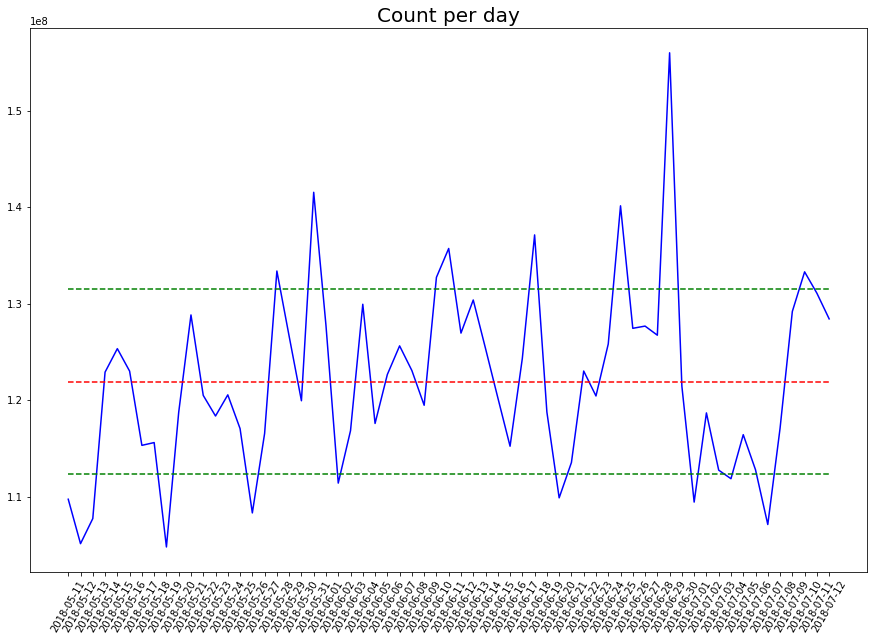

In [7]:
i = 0
plot_df(df_by_dimensions[i],dimensions[i], volume_label, volume_label + ' per ' + dimensions[i], True)

This plot represents the sum of logs per day over all the time period. We can see on this plot that there seems to be a week seasonality and maybe a increasing trend (needs more data to identify it).

## Per hour 

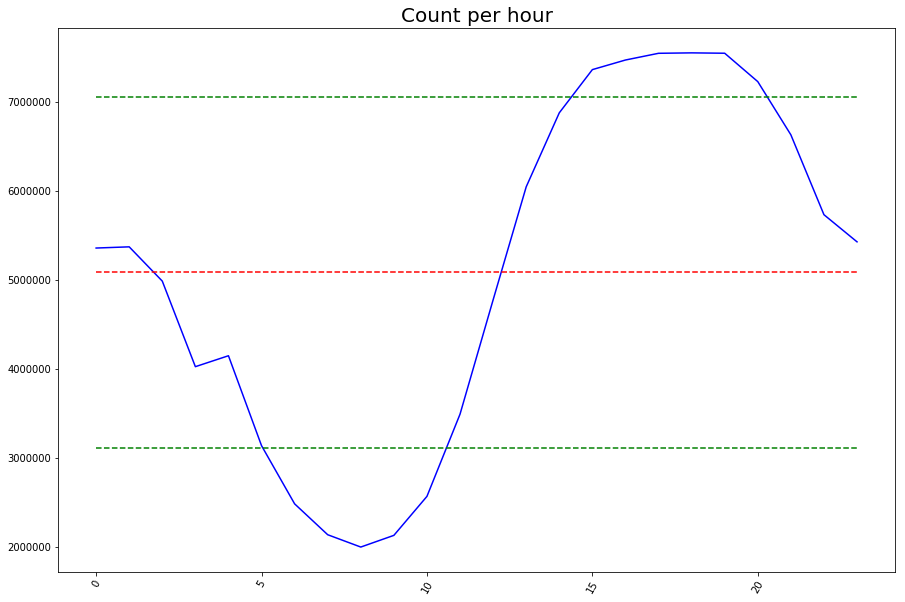

In [8]:
i = 1
plot_df(df_by_dimensions[i],dimensions[i], volume_label, volume_label + ' per ' + dimensions[i], True)

# Main aggregations

## Retailers (cbs_media_source_id)

In [25]:
aggregator = "cbs_page_type"
dimensions_with_aggregator = list(dimensions)
dimensions_with_aggregator.append(aggregator)

In [26]:
compute_query(dimensions_with_aggregator, nb_days, table_name)

hive -e "select day,hour,cbs_page_type, sum(A.total) as total, sum(A.c) as c 
 from (select day,hour,cbs_page_type,1 as total, CASE WHEN label_nbclicks>0 THEN 1 ELSE 0 END as c 
 from cbsdata.bid_request_imp_clicks 
 where day < current_date  ) as A 
 group by day,hour,cbs_page_type;">clicks_day_hour_cbs_page_type_alldays.txt


In [27]:
filename = get_file_path(dimensions_with_aggregator, nb_days, table_name, with_label_number = False)
df_clicks = read_and_clean(filename,dimensions_with_aggregator, dimensions_with_aggregator, ascending = True)

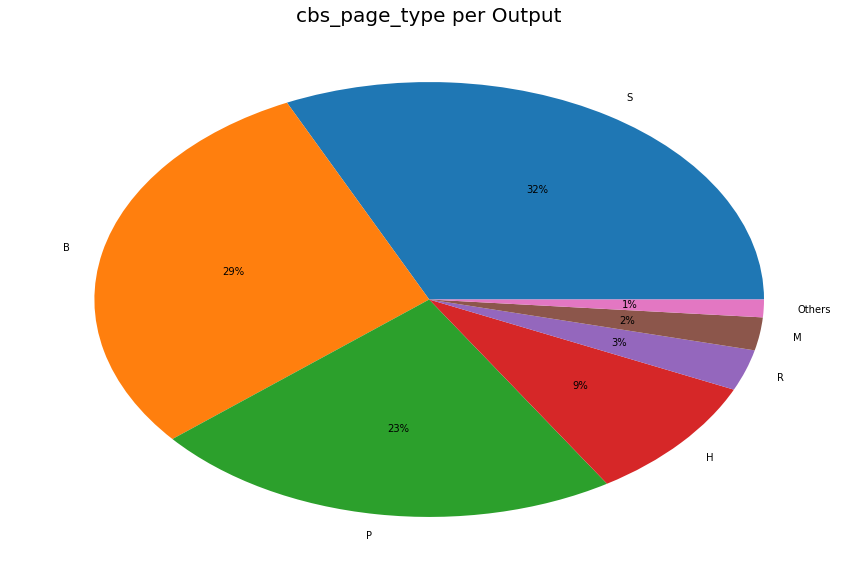

In [32]:
cropping_threshold = 1
volume_label = "Output"
plt.figure(figsize=(15, 10))
[top_ids, df_crop] = get_top_values_for_aggregator(df_clicks, aggregator, volume_label, cropping_threshold = cropping_threshold, subplot=221)
plot_pie_df_subplot(df_crop, "Percentage " + volume_label, aggregator,  aggregator + " per " + volume_label, 111)

In [33]:
display_rows_by_aggretor(df_clicks, aggregator, volume_label, top_ids[:-1])

+--------------------+--------+-------+------------------+
|                    |  Mean  |  Std  | Std/Mean percent |
+====================+========+=======+==================+
| S: Output per day  | 58,245 | 6,523 | 11.2%            |
+--------------------+--------+-------+------------------+
| S: Output per hour | 2,428  | 1,043 | 43.0%            |
+--------------------+--------+-------+------------------+
| B: Output per day  | 53,001 | 5,219 | 9.8%             |
+--------------------+--------+-------+------------------+
| B: Output per hour | 2,209  | 721   | 32.6%            |
+--------------------+--------+-------+------------------+
| P: Output per day  | 41,560 | 3,699 | 8.9%             |
+--------------------+--------+-------+------------------+
| P: Output per hour | 1,732  | 511   | 29.5%            |
+--------------------+--------+-------+------------------+
| H: Output per day  | 16,908 | 2,224 | 13.2%            |
+--------------------+--------+-------+-----------------

### Analyse one retailer 

In [34]:
id = "S"
df_aggregator = df_clicks[df_clicks[aggregator] == id]
[df_aggregator_by_day, df_aggregator_by_hour] = split_day_hour(df_aggregator)

In [35]:
rows = [["", "Mean", 'Std', "Std/Mean percent"]]
update_rows(rows, [(df_aggregator_by_day, "day"), (df_aggregator_by_hour, "hour")], volume_labels, str(id))
display(rows)

+--------------------+-----------+-----------+------------------+
|                    |   Mean    |    Std    | Std/Mean percent |
+====================+===========+===========+==================+
| S: Count per day   | 8,242,513 | 1,318,405 | 16.0%            |
+--------------------+-----------+-----------+------------------+
| S: Count per hour  | 343,542   | 149,341   | 43.5%            |
+--------------------+-----------+-----------+------------------+
| S: Output per day  | 58,245    | 6,523     | 11.2%            |
+--------------------+-----------+-----------+------------------+
| S: Output per hour | 2,428     | 1,043     | 43.0%            |
+--------------------+-----------+-----------+------------------+
| S: Ratio per day   | 0.720     | 0.090     | 12.4%            |
+--------------------+-----------+-----------+------------------+
| S: Ratio per hour  | 0.710     | 0.090     | 12.5%            |
+--------------------+-----------+-----------+------------------+


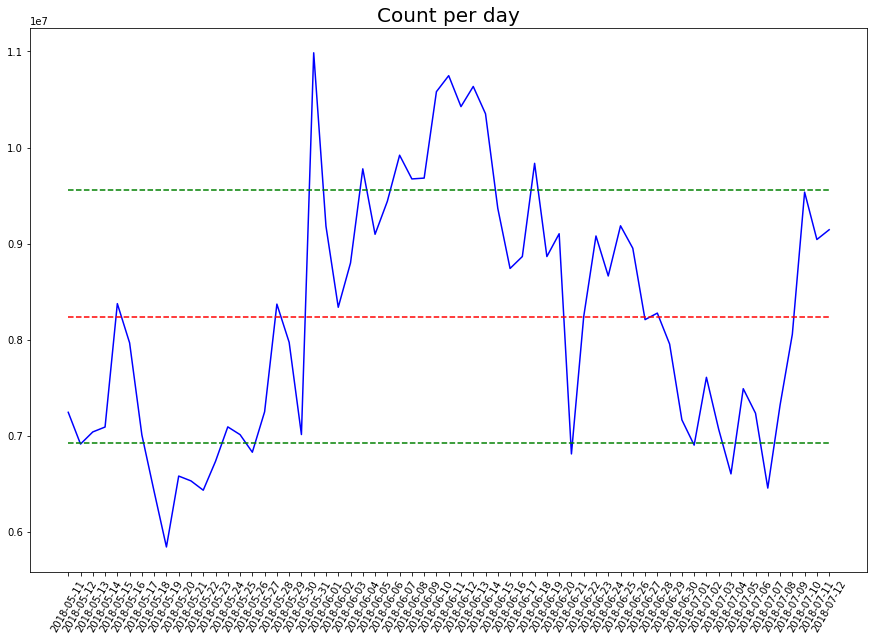

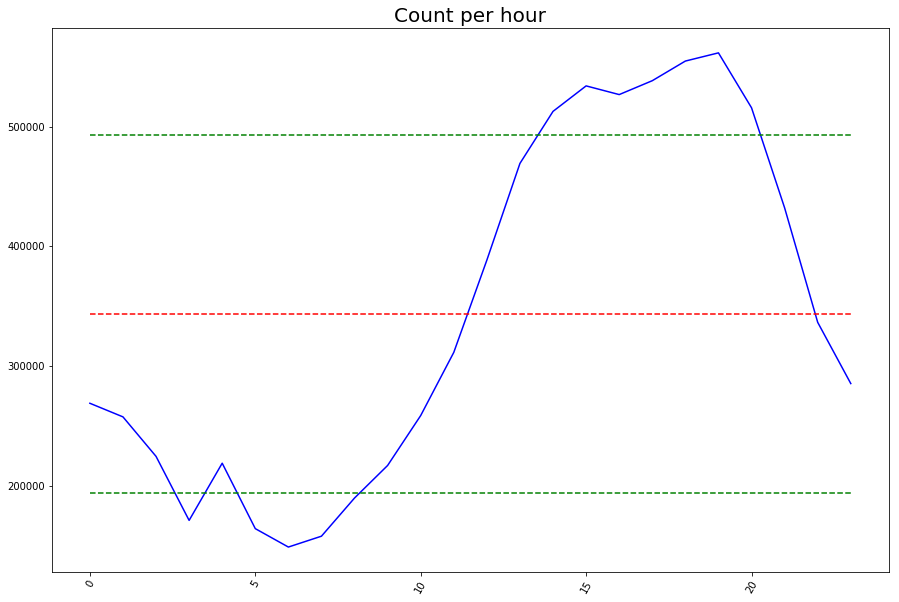

In [37]:
volume_label = "Count"
plot_df(df_aggregator_by_day,"day", volume_label, volume_label+ " per day", True)
plot_df(df_aggregator_by_hour,"hour", volume_label, volume_label+ " per hour", True)